In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from __future__ import print_function
from ortools.constraint_solver import pywrapcp
from ortools.constraint_solver import routing_enums_pb2

# **Google OR Tools**
> Open Source Software for *Combinatorial Optimization*


### What is an Optimisation Problem 
**Goal:** To find the best solution to a problem out of a large set of possible solutions. 
> "Best" can be either a *maximum* or a *minimum*.

### Elements of an Optimization Problem
* **Decision Variables** - A set of variables whose values we can change to find an optimal solution.
* **Objective Function** - The quantity we want to optimize (Minimize or Maximize, eg. Minimize Cost).
* **Bounds** - A range on the decision variables, defining what values are allowed. 
* **Constraints** - Restrictions on the set of possible solutions, based on the specific requirements of the problem.

> **Note:** The first step in solving an optimization problem is identifying the objective, variables and constraints.

## Our Problem Requirement
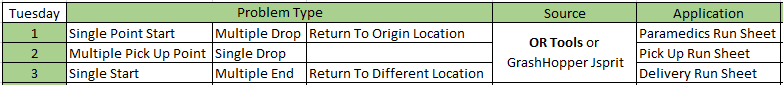
> <b>All the above problem types are Routing based Problems. Let's explore routing problems first.</b>

## Routing Problems
**Objective:** To find the optimal set of routes for a fleet of vehicles delivering goods or services to various locations. 
> Optimal Routes: Routes with the least total distance (Minimize the total route cost)



**Example Problem - FedEx Delivery**

The delivery person will calculate different routes for going to all the 6 destination and then come up with the shortest route.

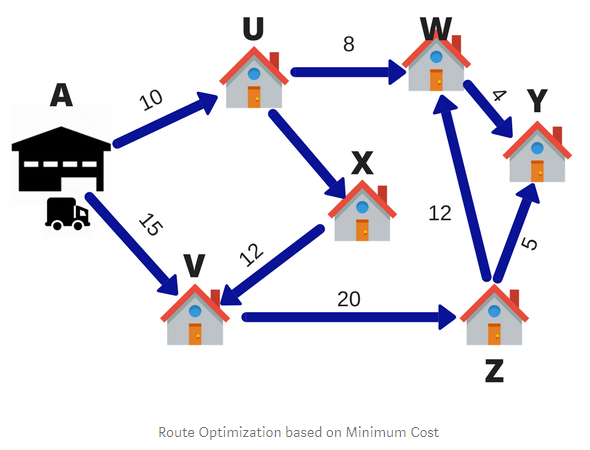

### Possible Constraints:
1. <b><u>Capacity Constraints:</u></b> 

The vehicles need to pick up items at each location they visit, but have a maximum carrying capacity.
>There can be different vehicles with different capacities. 
> >In more complex CVRPs, each vehicle might carry several different types of cargo, with a maximum capacity for each type.
<br>For example, a fuel delivery truck might carry several types of fuel, using multiple tanks with differing capacities.

2. <b><u>Time Window Constraints:</u></b> 

Scheduling Visits (Customers are available only during specific time windows). Vehicles must visit a location within its time window.

3. <b><u>Resource Constraints:</u></b>

*This is a resource based constraint at the depot also known as <b> loading and unloading constraints* 

There can be limited number of loading docks. (Say two, then at most two vehicles can be loaded or unloaded at the same time. As a result, some vehicles must wait for others to be loaded, delaying their departure from the depot. 

4. <b><u>Intercustomer Pickup and Delivery Request
    
There can be **intercustomer transportation requests** of goods in which goods are taken directly from one customer to another. 
> “Goods” may be passengers, as in the well-known dial-a-ride problem.

**Example:** Door to door transportation of elderly and disabled persons (users). Several users are transported in the same vehicle (say minibus).
<br> A time window can be requested from the user to pickup or delivery.

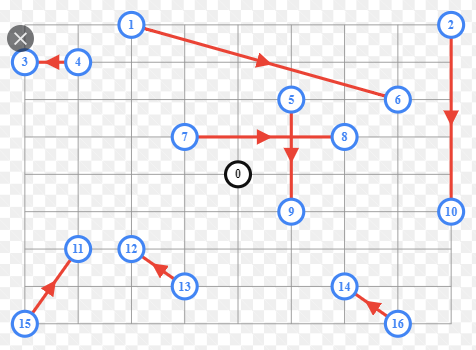

Each vehicle picks up items at various locations and drops them off at others. 
> We have to put a constraint that each item must be picked up and delivered by the same vehicle. 


## Different Types of VRP
1. Travelling Salesman Problem (TSP)
2. Vehicle Routing Problem (VRP)
3. Capacitated Vehicle Routing Problem (CVRP)
4. Vehicle Routing with Pickups and Deliveries (VRPPW)
5. Vehicle Routing Problem with Time Windows (VRPTW)
6. VRPTW with Resource Constraints
7. Penalties and Dropping Visits (CVRP)
8. Open Vehicle Routing Problem (OVRP): Vehicles are not required to return to the depot.

### 1. Travelling Salesman Problem (TSP)
This is a vehicle routing problem for a single vehicle.
<br>Goal: Find the shortest route for a salesman who needs to visit customers at different locations and return to the starting point.
> Single Point Start -> Multiple Drop -> Origin Location

* OBJECTIVE - Minimize the total route cost 
* VARIABLES - distance_matrix, num_locations, num_vehicles, depot

> > **Input: num_Vehicles = 1, depot = 0
**

#### Procedure To Solve TSP (VRP with num_vehicles = 1)

1.  Input the variables 
* Create the routing model
* Create The Distance Callback
* Set The Cost of Travel
* Set search parameters and Solve
* Output the Objective & Route

In [3]:
# 1. INPUT THE VARIABLES

def create_data_model():
    """Stores the data for the problem."""
    data = {}
    data['distance_matrix'] = [
        [0, 2451, 713, 1018, 1631, 1374, 2408, 213, 2571, 875, 1420, 2145, 1972],
        [2451, 0, 1745, 1524, 831, 1240, 959, 2596, 403, 1589, 1374, 357, 579],
        [713, 1745, 0, 355, 920, 803, 1737, 851, 1858, 262, 940, 1453, 1260],
        [1018, 1524, 355, 0, 700, 862, 1395, 1123, 1584, 466, 1056, 1280, 987],
        [1631, 831, 920, 700, 0, 663, 1021, 1769, 949, 796, 879, 586, 371],
        [1374, 1240, 803, 862, 663, 0, 1681, 1551, 1765, 547, 225, 887, 999],
        [2408, 959, 1737, 1395, 1021, 1681, 0, 2493, 678, 1724, 1891, 1114, 701],
        [213, 2596, 851, 1123, 1769, 1551, 2493, 0, 2699, 1038, 1605, 2300, 2099],
        [2571, 403, 1858, 1584, 949, 1765, 678, 2699, 0, 1744, 1645, 653, 600],
        [875, 1589, 262, 466, 796, 547, 1724, 1038, 1744, 0, 679, 1272, 1162],
        [1420, 1374, 940, 1056, 879, 225, 1891, 1605, 1645, 679, 0, 1017, 1200],
        [2145, 357, 1453, 1280, 586, 887, 1114, 2300, 653, 1272, 1017, 0, 504],
        [1972, 579, 1260, 987, 371, 999, 701, 2099, 600, 1162, 1200, 504, 0],
    ]  # yapf: disable
    data['num_vehicles'] = 1
    data['depot'] = 0
    return data
# Instantiate the data problem.
data = create_data_model()

display(pd.DataFrame(data['distance_matrix']))

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0,2451,713,1018,1631,1374,2408,213,2571,875,1420,2145,1972
1,2451,0,1745,1524,831,1240,959,2596,403,1589,1374,357,579
2,713,1745,0,355,920,803,1737,851,1858,262,940,1453,1260
3,1018,1524,355,0,700,862,1395,1123,1584,466,1056,1280,987
4,1631,831,920,700,0,663,1021,1769,949,796,879,586,371
5,1374,1240,803,862,663,0,1681,1551,1765,547,225,887,999
6,2408,959,1737,1395,1021,1681,0,2493,678,1724,1891,1114,701
7,213,2596,851,1123,1769,1551,2493,0,2699,1038,1605,2300,2099
8,2571,403,1858,1584,949,1765,678,2699,0,1744,1645,653,600
9,875,1589,262,466,796,547,1724,1038,1744,0,679,1272,1162


In [4]:
# 2. CREATE THE ROUTING MODEL

# Create the routing index manager (Manager for any Distance Matrix NodeIndex <-> Routing variable index conversion)
# Parameters (num_locations, num_vehicles, starts_ends)
manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']), data['num_vehicles'], data['depot'])

# Create Routing Model.
routing = pywrapcp.RoutingModel(manager)

In [5]:
# 3. DISTANCE CALLBACK 

# It takes any pair of locations and returns the distance between them
def distance_callback(from_index, to_index):
    """Returns the distance between the two nodes."""
    # Convert from routing variable Index to distance matrix NodeIndex.
    
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return data['distance_matrix'][from_node][to_node]

#The following function registers distance_callback with the solver
transit_callback_index = routing.RegisterTransitCallback(distance_callback)
      

In [6]:
# 4. SET THE COST OF EACH TRAVEL

# Define cost of each arc.
# Parameters (evaluator_index)
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

In [29]:
# 5(A) SET SEARCH PARAMETERS (Setting First Solution Heuristic)

search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = (routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
#search_parameters.local_search_metaheuristic = (routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
#search_parameters.time_limit.seconds = 30


# 5(B) SOLVE THE PROBLEM
solution = routing.SolveWithParameters(search_parameters)

In [30]:
# 6. OUTPUT THE OBJECTIVE & ROUTE

def print_solution(manager, routing, solution):
    """Prints solution on console."""
    print('Objective: {} miles'.format(solution.ObjectiveValue()))
    index = routing.Start(0)
    #print('index: \n',index)
    plan_output = 'Route for vehicle 0:\n'
    #print('plan_output: \n',plan_output)
    route_distance = 0
    while not routing.IsEnd(index):
        plan_output += ' {} ->'.format(manager.IndexToNode(index))
        previous_index = index
        index = solution.Value(routing.NextVar(index))
        route_distance += routing.GetArcCostForVehicle(previous_index, index, 0)
        #print('plan_output: \n',plan_output)   
        #print('previous_index: \n',previous_index)
        #print('index: \n',manager.IndexToNode(index))
        #print('route_distance: \n',route_distance)
        #print('--------------------------------')
    plan_output += ' {}\n'.format(manager.IndexToNode(index))
    #print(plan_output)
    plan_output += 'Route distance: {}miles\n'.format(route_distance)
    print(plan_output)

In [31]:
# PRINT SOLUTION ON THE CONSOLE
if solution:
    print_solution(manager, routing, solution)


Objective: 7569 miles
Route for vehicle 0:
 0 -> 7 -> 2 -> 3 -> 6 -> 8 -> 1 -> 11 -> 12 -> 4 -> 5 -> 10 -> 9 -> 0
Route distance: 7569miles



<center><b>OUTPUT FORMAT OF VRP</b></center> 

| Iteration | plan_output                                                         | previous_index | index | route_distance |
|-----------|---------------------------------------------------------------------|----------------|-------|----------------|
| 1         | 0 ->                                                                | 0              | 7     | 213            |
| 2         | 0 -> 7 ->                                                           | 7              | 2     | 1064           |
| 3         | 0 -> 7 -> 2 ->                                                      | 2              | 3     | 1419           |
| 4         | 0 -> 7 -> 2 -> 3 ->                                                 | 3              | 4     | 2119           |
| 5         | 0 -> 7 -> 2 -> 3 -> 4 ->                                            | 4              | 12    | 2490           |
| 6         | 0 -> 7 -> 2 -> 3 -> 4 -> 12 ->                                      | 12             | 6     | 3191           |
| ...       | ...                                                                 | ...            | ...   | ...            |
| 13        | 0 -> 7 -> 2 -> 3 -> 4 -> 12 -> 6 -> 8 -> 1 -> 11 -> 10 -> 5 -> 9 -> | 9              | 0     | 7293           |


><b><br>Route for vehicle 0:
<br>0 -> 7 -> 2 -> 3 -> 4 -> 12 -> 6 -> 8 -> 1 -> 11 -> 10 -> 5 -> 9 -> 0

### 2. Vehicle Routing Problem (VRP)
A more general version of the TSP is the vehicle routing problem (VRP), in which there are multiple vehicles.

* OBJECTIVE - Minimize the longest single route
* VARIABLES - distance_matrix, num_locations, num_vehicles, depot
* <b>BOUND - We need to set an upper bound for each vehicle's travel distance. (In this case, taken to be 3000)</b>

> > **Input: num_vehicles > 1, depot = 0 **

<img src="attachment:image.png" height=550 width=500>

#### Procedure To Solve VRP (VRP with num_vehicles > 1)
> Same as TSP with the addition of 
> > Distance Dimension - It computes the cumulative distance traveled by each vehicle along its route.

1. Input the variables 
* Create the routing model
* Create The Distance Callback
* Set The Cost of Travel
* **Add a Distance Dimension**
* Set search parameters and Solve
* Output the Objective & Route

#### Dimension
Routing programs use dimensions to keep track of quantities that accumulate over a vehicle's route such as the travel time or distance or the carrying capacity.

In [10]:
# Add Distance constraint.

dimension_name = 'Distance'
routing.AddDimension(
    transit_callback_index,
    0,  # no slack
    3000,  # vehicle maximum travel distance
    True,  # start cumul to zero
    dimension_name)
distance_dimension = routing.GetDimensionOrDie(dimension_name)

# The next line sets a cost proportional to the maximum of the total distances along each route
distance_dimension.SetGlobalSpanCostCoefficient(100)

<h3><center>OUTPUT FOR VRP</center></h3> 

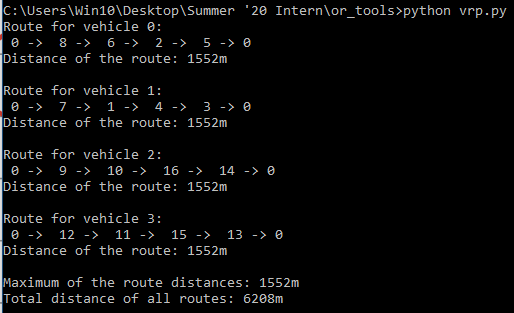

<h3><center>Graphical Presentation</center></h3> 

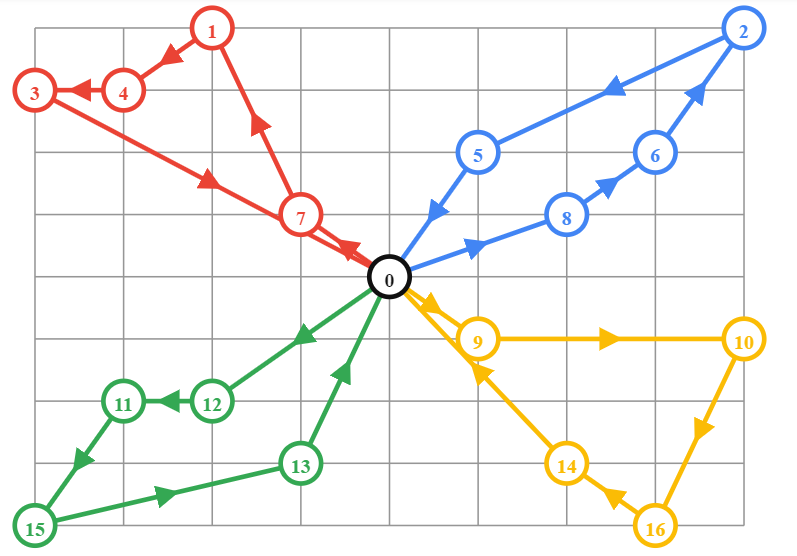

##### 3. Capacitated Vehicle Routing Problem (CVRP)
VRP with capacity constraints, in which vehicles with limited carrying capacity need to <b>pick up</b> or <b>deliver</b> items at various locations.

<u>The problem is to pick up the items for the least cost, while never exceeding the capacity of the vehicles.</u>
> Note: In the following example, we assume that all items are being picked up. 
> > At each location there is a demand corresponding to the quantity of the item to be picked up. Also, each vehicle has a maximum capacity of 15. 

* OBJECTIVE - To find an assignment of routes to vehicles that has the shortest total distance.
* VARIABLES - distance_matrix, num_vehicles, depot, **demands, vehicle_capacities**
* <B>CONSTRAINT - Capacity (the total amount a vehicle is carrying never exceeds its capacity).
* BOUND - We need to set an upper bound for each vehicle's capacity. (In this case, taken to be 15 for each)</B>
 
<img src="attachment:image.png" height=500 width=500>

#### Procedure To Solve CVRP (VRP with Capacity Constraints)
> Same as VRP with the addition of 
> > <b>Demand Callback</b>    - It returns the demand at each location
<br><b>Capacity Dimension</b> - It computes the weight of the load a vehicle is carrying- a quantity that accumulates over the route 

1.  Input the variables 
* Create the routing model
* Create The Distance Callback
* Set The Cost of Travel
* **Create the Demand Callback**
* **Add a Capacity Dimension**
* Set search parameters and Solve
* Output the Objective & Route

In [11]:
### Additional Data To Be Input
data['demands'] = [0, 1, 1, 2, 4, 2, 4, 8, 8, 1, 2, 1, 2, 4, 4, 8, 8]
data['vehicle_capacities'] = [15, 15, 15, 15]

In [12]:
# 5. DEMAND CALLBACK 

# It returns the demand at each location
def demand_callback(from_index):
    """Returns the demand of the node."""
    # Convert from routing variable Index to demands NodeIndex.
    from_node = manager.IndexToNode(from_index)
    return data['demands'][from_node]

#The following function registers demand_callback with the solver
demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)      

In [ ]:
# 6. CAPACITY DIMENSION

routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,  # null capacity slack
        data['vehicle_capacities'],  # vehicle maximum capacities
        True,  # start cumul to zero
        'Capacity')

<h3><center>OUTPUT FOR CVRP</center></h3> 

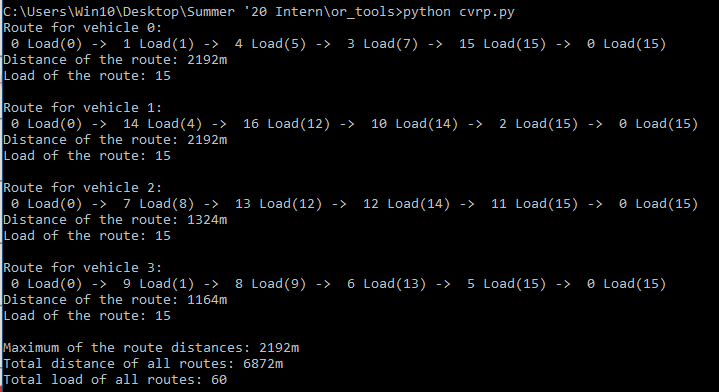

<h3><center>Graphical Presentation</center></h3> 

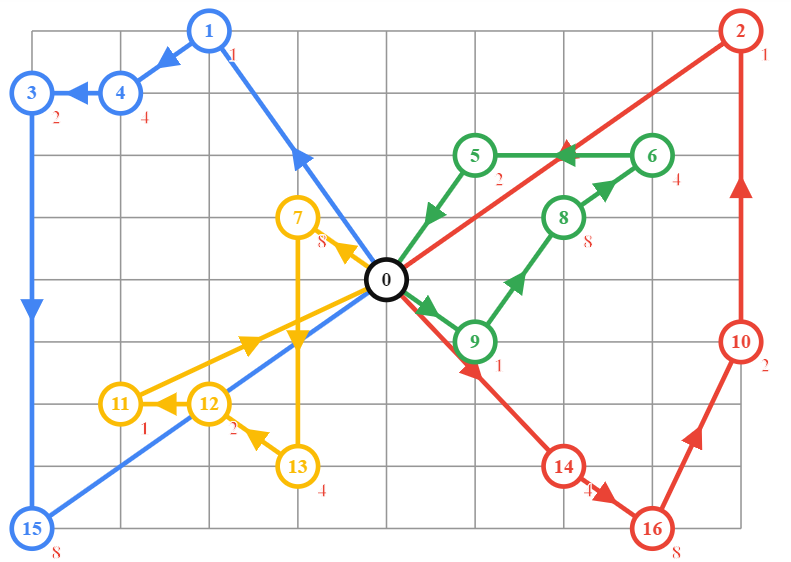

### 4. Vehicle Routing with Pickups and Deliveries (VRPPD) 
VRP in which each vehicle picks up items at various locations and drops them off at others. 

<u>The problem is to assign routes for the vehicles to pick up and deliver all the items, while minimizing the length of the longest route. </u> 

>Note: Customers that receive goods from the depot are known as linehauls or deliveries; customers who send goods are backhauls or pickups.

* OBJECTIVE - To find an assignment of routes to vehicles that has the shortest total distance.
* VARIABLES - distance_matrix, num_locations, num_vehicles, depot, **pickups_deliveries**
* <B>CONSTRAINT - Pickup and Delivery Request By Customers (each item must be picked up and delivered by the same vehicle)

<img src="attachment:image.png" height=500 width=500>

#### Procedure To Solve VRPPD (VRP with  inter-customer transportation request of goods)

1.  Input the variables 
* Create the routing model
* Create The Distance Callback
* Set The Cost of Travel
* Add a Distance Dimension
* **Define Transportation Requests**
* Set search parameters and Solve
* Output the Objective & Route

In [1]:
### Additional Data To Be Input
data['pickups_deliveries'] = [
    [1, 6],
    [2, 10],
    [4, 3],
    [5, 9],
    [7, 8],
    [15, 11],
    [13, 12],
    [16, 14],
]

NameError: name 'data' is not defined

In [ ]:
# 6. DEFINE PICKUP AND DELIVERY REQUESTS

for request in data['pickups_deliveries']: 
    pickup_index = manager.NodeToIndex(request[0])         # Here NodeToIndex Used
    delivery_index = manager.NodeToIndex(request[1])
    
    # Next line creates a pickup and delivery request for an item. 
    routing.AddPickupAndDelivery(pickup_index, delivery_index)
    
    # The following line adds the requirement that each item must be picked up and delivered by the same vehicle.
    routing.solver().Add(
        routing.VehicleVar(pickup_index) == routing.VehicleVar(delivery_index))
    
    # The following line adds the requirement that each item must be picked up before it is delivered.
    routing.solver().Add(
        distance_dimension.CumulVar(pickup_index) <= distance_dimension.CumulVar(delivery_index))

<h3><center>OUTPUT FOR VRPPD</center></h3> 

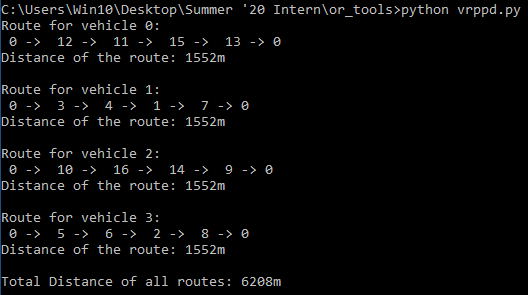

<h3><center>Graphical Presentation</center></h3> 

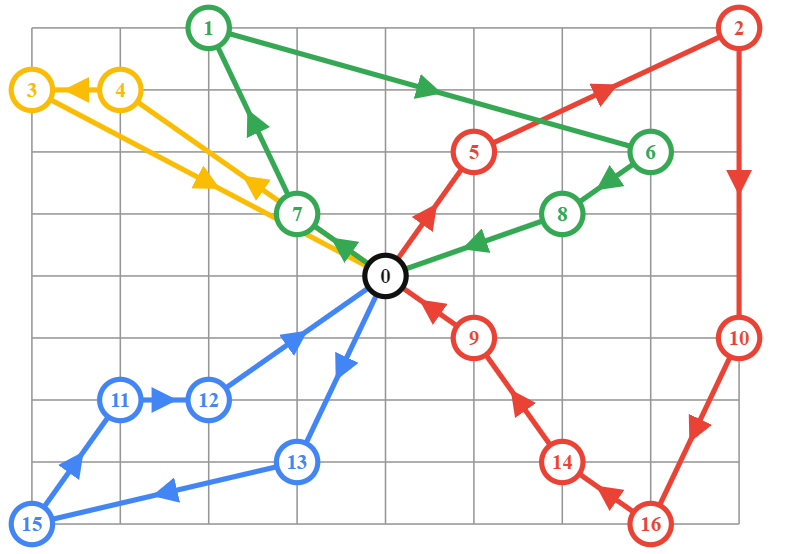

### 5. Vehicle Routing Problem with Time Windows (VRPTW)
VRP with time windows, where the vehicles must visit the locations in specified time intervals.
* OBJECTIVE - Minimize the total travel time of the vehicles.
* VARIABLES - *time_matrix*, num_locations, num_vehicles, depot, *time_windows*
* <B>CONSTRAINT - Time Windows (Vehicles must visit a location within its time window).
* BOUND - We need to set an upper bound for each vehicle's travel time with allowed slack. (In this case, taken to be 30 for each)</B>
>  <br><b>Since the problem involves time windows, the data include a time matrix, which contains the travel times between locations. </b>
> ><b><u>time_matrix:</u> An array of travel times between locations.
    <br><u>time_windows:</u> An array of time windows for the locations. (requested times for a visit)</b>

Note: If all vehicles travel at the same speed, you will get the same solution if you use a distance matrix or a time matrix, since travel distances are a constant multiple of travel times.

<img src="attachment:image.png" height=500 width=500>

#### Procedure To Solve VRPTW (VRP with Time Windows)
> Same as VRP with the addition of 
> > <b>Time Callback</b>    - It returns the travel time between the two locations.
<br><b>Time Window Constraints</b> - It tracks each vehicle's cumulative travel time and enforces the constraint that a vehicle can only visit a location within the location's time window. 

1.  Input the variables 
* Create the routing model
* Create The **Time Callback**
* Set The Cost of Travel
* **Add a Time Dimension**
* **Add time window constraints for each location except depot**
* **Add time window constraints for each vehicle start node**
* **Instantiate route start and end times to produce feasible times**
* Set search parameters and Solve
* Output the Objective & Route

In [2]:
# 3. TIME CALLBACK

# It takes any pair of locations and returns the travel time between them
def time_callback(from_index, to_index):
    """Returns the travel time between the two nodes."""
    # Convert from routing variable Index to time matrix NodeIndex.
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return data['time_matrix'][from_node][to_node]

#The following function registers time_callback with the solver
transit_callback_index = routing.RegisterTransitCallback(time_callback)

NameError: name 'routing' is not defined

In [3]:
# 5. TIME DIMENSION 

time = 'Time'
    routing.AddDimension(
        transit_callback_index,
        30,  # allow waiting time
        30,  # maximum time per vehicle
        False,  # Don't force start cumul to zero.
        time)
    time_dimension = routing.GetDimensionOrDie(time)


IndentationError: unexpected indent (<ipython-input-3-436fa1891328>, line 4)

In [4]:
# 6. ADD TIME WINDOW CONSTRAINTS FOR EACH LOCATION EXCEPT DEPOT

for location_idx, time_window in enumerate(data['time_windows']):
    if location_idx == 0:
        continue
    index = manager.NodeToIndex(location_idx)
    time_dimension.CumulVar(index).SetRange(time_window[0], time_window[1])

NameError: name 'data' is not defined

In [5]:
# 7. ADD TIME WINDOW CONSTRAINTS FOR EACH VEHICLE START NODE

for vehicle_id in range(data['num_vehicles']):
    index = routing.Start(vehicle_id)
    time_dimension.CumulVar(index).SetRange(data['time_windows'][0][0], data['time_windows'][0][1])

NameError: name 'data' is not defined

In [6]:
# 8. INSTANTIATE ROUTE START AND END TIMES TO PRODUCE FEASIBLE TIMES

for i in range(data['num_vehicles']):
    routing.AddVariableMinimizedByFinalizer(
        time_dimension.CumulVar(routing.Start(i)))
    routing.AddVariableMinimizedByFinalizer(
        time_dimension.CumulVar(routing.End(i)))

NameError: name 'data' is not defined

<h3><center>OUTPUT FOR VRPTW</center></h3> 

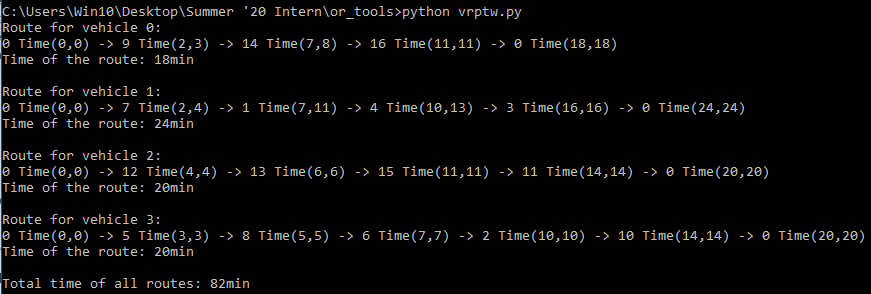

### 6. VRPTW with Resource Constraints
VRP with time windows and additional resource constraints (at the depot).
* OBJECTIVE - Minimize the total travel time of the vehicles.
* VARIABLES - time_matrix, time_windows, num_locations, num_vehicles, depot, **vehicle_load_time**, **vehicle_unload_time**, **depot_capacity**
* <B>CONSTRAINT - 
<br>Time Windows (Vehicles must visit a location within its time window).
<br>Resource Constraint (Loading and Unloading Constraints at the depot
* BOUND - We need to set an upper bound for each vehicle's travel time with allowed slack. (In this case, taken to be 30 for each)</B>

> vehicle_load_time: The time required to load a vehicle.
> <br>vehicle_unload_time: The time required to unload a vehicle.
> <br>depot_capacity: The maximum number of vehicles that can load or unload at the same time.

#### Procedure To Solve VRPTW_RC (VRPTW with Resource Constraints)
> Same as VRPTW with the addition of 
> > <b>Time windows for loading and unloading</b> - variable time windows (width specified by vehicle_load_time & vehicle_unload_time)
<br><b>Resource Constraints at the depot</b> - It creates the contraint that at most two vehicles can be loaded or unloaded at the same time.

1.  Input the variables 
* Create the routing model
* Create The Time Callback
* Set The Cost of Travel
* Add a Time Dimension
* Add time window constraints for each location except depot
* Add time window constraints for each vehicle start node
* **Add time windows for loading and unloading**
* **Add Resource Constraints at the depot**
* Instantiate route start and end times to produce feasible times
* Set search parameters and Solve
* Output the Objective & Route

In [7]:
# ADD TIME WINDOWS FOR LOADING AND UNLOADING

solver = routing.solver()
intervals = []
for i in range(data['num_vehicles']):
    # Add time windows at start of routes
    intervals.append(
        solver.FixedDurationIntervalVar(
            time_dimension.CumulVar(routing.Start(i)),
            data['vehicle_load_time'], 'depot_interval'))
    # Add time windows at end of routes.
    intervals.append(
        solver.FixedDurationIntervalVar(
            time_dimension.CumulVar(routing.End(i)),
            data['vehicle_unload_time'], 'depot_interval'))

NameError: name 'routing' is not defined

In [ ]:
# ADD RESOURCE CONSTRAINTS AT THE DEPOT

depot_usage = [1 for i in range(len(intervals))]
solver.Add(
    solver.Cumulative(intervals, depot_usage, data['depot_capacity'], 'depot'))

### 7. CVRP with Penalties and Dropping Visits
How to handle routing problems that have no feasible solution, due to constraints ?
> <b>For example, if you are given a VRP with capacity constraints in which the total demand at all locations exceeds the total capacity of the vehicles, no solution is possible.</b>

In such cases, the vehicles must drop visits to some locations. The problem is how to decide which visits to drop.

<br><b>To solve the problem, we introduce new costs—called penalties—at all locations. Whenever a visit to a location is dropped, the penalty is added to the total distance traveled. The solver then finds a route that minimizes the total distance plus the sum of the penalties for all dropped locations.</b>

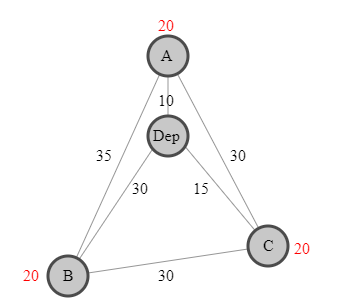
<center> Simple VRP with Capacity Constraint (num_vehicle = 1, capacity = 50) </center>
>  <b>To solve the above problem, we assign a large penalty—say 100—to each location. After detecting that the problem is infeasible, the solver drops location B and returns the following route:
>> Depot -> A -> C -> Depot </b>

* OBJECTIVE - To find routes vehicles that has the shortest total distance + **the sum of the penalties for all dropped locations.**
* VARIABLES - distance_matrix, num_vehicles, depot, demands, vehicle_capacities
* CONSTRAINT - Capacity (the total amount a vehicle is carrying never exceeds its capacity).
* BOUND - We need to set an upper bound for each vehicle's capacity. (In this case, taken to be 15 for each)

<img src="attachment:image.png" height=500 width=500>

#### Procedure To Solve CVRP with penalties and dropping visits
> Same as CVRP with the addition of 
> > <b>Penalties</b>    - It is added to the total distance traveled.
<br><b>Display Of Dropped Nodes in the Output</b> 

1.  Input the variables 
* Create the routing model
* Create The Distance Callback
* Set The Cost of Travel
* Create the Demand Callback
* Add a Capacity Dimension
* **Add the Penalties**
* Set search parameters and Solve
* Output the Objective & Route - **Display the dropped nodes**

In [8]:
# 7. ADD THE PENALTIES

# Allow to drop nodes.
penalty = 1000
# For all the vehicles except depot - Add the penalty
for node in range(1, len(data['distance_matrix'])):
    routing.AddDisjunction([manager.NodeToIndex(node)], penalty)

NameError: name 'data' is not defined

In [9]:
# DISPLAY THE DROPPED NODES

dropped_nodes = 'Dropped nodes:'
for node in range(routing.Size()):
    if routing.IsStart(node) or routing.IsEnd(node):
        continue
    if assignment.Value(routing.NextVar(node)) == node:
        dropped_nodes += ' {}'.format(manager.IndexToNode(node))
print(dropped_nodes)

NameError: name 'routing' is not defined

## Our Problem Requirement
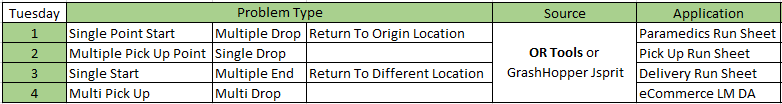

## Problem Type 1 (Paramedics Run Sheet)
> Single Point Start -> Multiple Drop -> Origin Location

* This is a type of Vehicle Routing Problem (num_vehicles -> num_paramedics, depot = 0) **[VRP Type 2]** 
* For num_paramedics=1, this problem converts into Travelling Salesman Problem **[VRP Type 1]**

## Problem Type 2 (Pick Up Run Sheet)
> Multiple Pick Up Point -> Single Drop

* This is a type of **Capacitated Vehicle Routing Problem (CVRP)** in which all items are being <b><u>picked up</u></b> **[VRP Type 3]**
* CVRP is a Vehicle Routing Problem with Capacity Constraints.

## Problem Type 3 (Delivery Run Sheet)
> Single Start -> Multiple End -> Return To Different Location 

* This is a type of **Capacitated Vehicle Routing Problem (CVRP)** in which all items are being <b><u>delivered</u></b> **[VRP Type 3]**
* In this case, we can think of the capacity constraint being applied when the vehicles leave the depot fully loaded.


## Problem Type 4 (Pickups and Deliveries)
> Multi Pick Up -> Multi Drop

* This is a type of **Vehicle Routing Problem With Pickups and Deliveries**  in which each vehicle picks up items at various locations and drops them off at others. **[VRP Type 4]**
*  The problem is to assign routes for the vehicles to pick up and deliver all the items, while minimizing the length of the longest route.